# Steam Sentiment Analysis Projekt - Emotionserkennung

## Einführung

In diesem Teil des Projekts untersuchen wir die Integration der **Emotionserkennung** in die Sentiment-Analyse von Steam Reviews. Emotionen sind ein wesentlicher Bestandteil von Rezensionen, insbesondere im Gaming-Bereich, und können uns helfen, die Nutzerabsicht besser zu verstehen. Unser Ziel ist es, durch die Erkennung von Emotionen zusätzliche Informationen für die Klassifikation von positiven und negativen Reviews zu gewinnen und dadurch die Genauigkeit des Modells zu verbessern.

### Warum verwenden wir Emotionserkennung?

Rezensionen enthalten häufig starke Emotionen, die Hinweise darauf geben können, ob ein Nutzer ein Spiel empfehlen würde oder nicht. Durch die Analyse dieser Emotionen hoffen wir, subtile Unterschiede in der Nutzerzufriedenheit zu erkennen, die durch eine reine Sentiment-Analyse möglicherweise übersehen werden. Die Integration von Emotionen könnte somit die Unterscheidung zwischen positiven und negativen Bewertungen verfeinern.

---

## Modell für die Emotionserkennung

Zur Emotionserkennung verwenden wir das Modell **SamLowe/roberta-base-go_emotions**, das auf dem **GoEmotions-Datensatz** von Google basiert. Dieser Transformer wurde auf 28 verschiedene Emotionen trainiert und bietet eine robuste Grundlage, um Emotionen in Texten zu analysieren.

- **Modell**: Fine-tuned Version des ```roberta-base``` Modells.
- **Datensatz**: GoEmotions von Google, enthält eine Vielzahl von Kommentaren aus dem Web.
- **Input und Output**: 
  - Input: *Text* 
  - Output: Eine der 28 möglichen Emotionen (z.B. Freude, Trauer, Ärger)

Der Grund für die Wahl dieses Modells liegt in seiner Flexibilität und der breiten Palette von Emotionen, die es erkennen kann. Es wird angenommen, dass bestimmte Emotionen eine starke Korrelation mit der Empfehlung oder Nicht-Empfehlung eines Spiels aufweisen, was die Genauigkeit der Vorhersagen verbessern könnte.

---

### Autoren
- Markus Grau, Daniel Kosma, Mikail Yildiz

## Libraries

In [1]:
import pandas as pd
pd.set_option('display.float_format', '{:.4f}'.format)
import numpy as np

import torch
from torch.utils.data import DataLoader, Dataset # PyTorch, für Neural Networks

from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForSequenceClassification # transformers, library für Auswerungen von Texten

from sklearn.model_selection import train_test_split # Train-Test Split

#plot libraries
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

In [2]:
df = pd.read_parquet("data/processed_data/steam_reviews_filtered.parquet") 

In [3]:
df.head(5)

,app_id,app_name,review_id,language,review,timestamp_created,timestamp_updated,recommended,votes_helpful,votes_funny,...,author.num_reviews,author.playtime_forever,author.playtime_last_two_weeks,author.playtime_at_review,author.last_played,publisher,genres,notes,cleaned_review,token_length
269238,620980,Beat Saber,79244667,english,"Since I am 80 + years old, it is very importan...",2020-11-14 10:51:22,2020-11-14 10:51:22,True,1493,176,...,1,2544.0000,0.0000,2451.0000,2020-12-30 09:08:22,Beat Games,[Indie],None,"since i am 80 + years old, it is very importan...",52
1776430,1113000,Persona 4 Golden,70806847,english,Please buy this game if you want more Persona ...,2020-06-15 02:03:47,2020-11-26 04:15:44,True,1490,31,...,12,9612.0000,0.0000,499.0000,2020-11-26 04:08:17,SEGA,[RPG],Alcohol Reference\r\nAnimated Blood\r\nLanguag...,please buy this game if you want more persona ...,18
1396365,1145360,Hades,75662801,english,You can date the medusa head. Post Launch Edi...,2020-09-08 19:18:50,2020-10-10 19:57:02,True,1486,745,...,7,3965.0000,0.0000,2445.0000,2020-12-16 12:52:51,Supergiant Games,"[Action, Indie, RPG]",None,you can date the medusa head.\n\npost launch e...,21
354159,1225330,NBA 2K21,75410143,english,There is very little difference from 2k20. The...,2020-09-04 06:20:35,2020-09-04 06:20:35,False,1484,99,...,1,698.0000,576.0000,121.0000,2021-01-15 00:10:47,2K,"[Simulation, Sports]",None,there is very little difference from 2k20. the...,79
2574101,105600,Terraria,78393147,english,---{Graphics}--- ✖ Masterpiece ✖ Beautiful ✅Go...,2020-10-30 12:14:22,2020-11-26 04:01:45,True,1461,156,...,13,2406.0000,0.0000,2406.0000,2020-10-24 08:38:17,None,None,None,---{graphics}---\n✖ masterpiece\n✖ beautiful\n...,459


## Vorbereitung
Da unser Datensatz sehr groß ist, und Transformer bei der Verarbeitung von großen Datensätzen sehr langsam ist, haben wir uns entschieden, den Datensatz für die ersten Resultate auf 10% zu reduzieren.

In [4]:
df_stratified, _ = train_test_split(df, test_size=0.9, stratify=df['recommended'], random_state=42) #statify wird benutzt um die Daten gleichmäßig aufzuteilen

In [5]:
df_stratified['recommended'].value_counts()

recommended
True     27916
False     7915
Name: count, dtype: int64

### Einlesen der GPU
Zuerst müssen wir die GPU aktivieren, um die Modelle schneller zu trainieren und zu testen.

In [3]:
# Prüfe, ob eine GPU verfügbar ist
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"GPU ist verfügbar: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("Keine GPU verfügbar, CPU wird verwendet")

GPU ist verfügbar: NVIDIA GeForce RTX 4070


## Funktionen und Settings

Um das Modell zu verwenden, definieren wir eine Funktion, die den Text als Input nimmt und die Emotionen zurückgibt.
Dazu verwenden wir noch den DataLoader, um die Daten in Batches zu laden und die Ergebnisse zu speichern. 

In [6]:
# Klasse für den Data Loader 
class EmotionDataset(Dataset):
    def __init__(self, reviews, tokenizer, max_length=512):
        self.reviews = reviews  # text das rein geht
        self.tokenizer = tokenizer  # tokenizer model
        self.max_length = max_length  # maximale länge des textes

    def __len__(self):
        return len(self.reviews)  # länge des textes returnen

    def __getitem__(self, idx):
        review = self.reviews.iloc[idx]['cleaned_review']  # review auslesen
        inputs = self.tokenizer(review, padding='max_length', truncation=True, max_length=self.max_length, return_tensors="pt")  # tokenisieren
        inputs = {key: value.squeeze(0) for key, value in inputs.items()}  # entfernen unnötiger dimensionen
        return inputs, self.reviews.iloc[idx]['review_id']

# Generische Funktion, um Emotionen im Batch zu erkennen
def predict_emotions_batch(batch, model):
    """Funktion evaluiert ein Modell auf einem Batch von Daten und gibt die Emotion-Wahrscheinlichkeiten zurück.

    Args:
        batch (torch.Dataloader): DataLoader Instanz der Eingabedaten im Batch.
        model (torch.AutoModelForSequenceClassification): Torch Modell für die Klassifikation.

    Returns:
        list: Liste mit den Wahrscheinlichkeiten für jede Emotion.
    """
    inputs = {key: val.to(device) for key, val in batch.items()}  # Batch auf die GPU verschieben
    outputs = model(**inputs)  # Modell-Durchlauf für den Batch
    scores = torch.nn.functional.softmax(outputs.logits, dim=-1).cpu()  # Logits in Wahrscheinlichkeiten umwandeln
    return scores.tolist()  # Wahrscheinlichkeiten für alle Emotionen zurückgeben

# Funktion zur Verarbeitung des gesamten DataFrames in Batches und Berechnung der Emotion Scores
def process_emotion_scores_with_dataloader(df, model, tokenizer, batch_size=16):
    """Funktion zur Verarbeitung des gesamten DataFrames in Batches und Berechnung der Emotion-Scores.

    Args:
        df (PandasDataFrame): Ein Pandas DataFrame mit den Daten für die Verarbeitung.
        model (torch.AutoModelForSequenceClassification): Torch Modell für die Emotionserkennung.
        tokenizer (torch.Autotokenizer): Tokenizer für die Verarbeitung der Daten.
        batch_size (int, optional): Die Größe der Batches. Standardwert ist 16.

    Returns:
        pd.DataFrame: DataFrame mit 'review_id' und den berechneten Emotion Scores als Liste.
    """
    emotion_scores = []
    review_ids = list(df['review_id'])

    # Dataset erstellen und mit DataLoader verbinden
    dataset = EmotionDataset(df, tokenizer) 
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    # Emotion-Scores in Batches berechnen
    for batch, ids in tqdm(dataloader, desc="Verarbeite Batches"):
        batch_scores = predict_emotions_batch(batch, model)
        emotion_scores.extend(batch_scores)

    # Rückgabe des DataFrames mit Emotion Scores
    return pd.DataFrame({'review_id': review_ids, 'emotion_scores': emotion_scores})

#funtkion um labels auf die scores zu mappen
def map_emotion_scores_to_dataframe(df: pd.DataFrame, emotion_scores_column: str = "emotion_scores") -> pd.DataFrame:
    """
    Mappt die Emotion Scores im DataFrame auf die entsprechenden Emotion Labels und gibt einen neuen DataFrame zurück.

    Args:
        df (pd.DataFrame): Der ursprüngliche DataFrame, der die Spalte mit den Emotion Scores enthält.
        emotion_scores_column (str, optional): Der Name der Spalte, die die Emotion Scores enthält. Standardwert ist "emotion_scores".

    Returns:
        pd.DataFrame: Ein DataFrame mit den Emotion Labels als Spalten und den zugehörigen Scores als Werten.
    """
    EMOTION_LABELS = [
        "admiration", "amusement", "anger", "annoyance", "approval", "caring",
        "confusion", "curiosity", "desire", "disappointment", "disapproval",
        "disgust", "embarrassment", "excitement", "fear", "gratitude", "grief",
        "joy", "love", "nervousness", "optimism", "pride", "realization",
        "relief", "remorse", "sadness", "surprise", "neutral"
    ]

    # Emotion Scores extrahieren und in einen neuen DataFrame umwandeln
    df_emotions = pd.concat([df["review_id"],pd.DataFrame(df[emotion_scores_column].tolist(), columns=EMOTION_LABELS)],axis=1)

    return df_emotions

## Testbeispiele

Hier testen wir zuerst einige Beispieltexte aus dem Internet und schauen, ob das Modell die Emotionen richtig erkennt.

In [9]:
emotion_reviews = [
    "I'm frustrated that my internet keeps disconnecting every five minutes.",
    "I'm disappointed that the game I've been waiting for all year turned out to be this bad.",
    "It's really unfortunate that my computer crashed when I needed it most.",
    "I would have preferred if this meeting was an email instead.",
    "I'm proud of my cat for waking me up at 3 AM again. It's quite persistent.",
    "This meal is not great. I prefer my pasta to be properly cooked.",
    "I have a lot of laundry to do this weekend, but I'll manage.",
    "This game keeps crashing when I make progress, which is really frustrating.",
    "It was really inconvenient that my car broke down in the middle of nowhere.",
    "It's inconvenient that the elevator is out of order again, but I will take the stairs.",
    "The power went out right when I was about to finish my work. It's not ideal.",
    "I regret spending the last of my savings on this gadget, which turned out to be broken.",
    "Another rainy day has ruined my plans, but I'll stay indoors and find something else to do.",
    "My neighbors were blasting music at 2 AM, which made it difficult for me to sleep.",
    "I burned dinner tonight, so we'll be ordering takeout instead."
]

df_test_emotion = pd.DataFrame({"cleaned_review": emotion_reviews, "review_id": range(1, len(emotion_reviews) + 1)})

## Emotionsmodell

### SamLowe/roberta-base-go_emotions

Das Modell ist eine feinabgestimmte Version von ```roberta-base```, die speziell für die Emotionserkennung in Texten entwickelt wurde.

Es klassifiziert Texte in eine von 28 möglichen Emotionen und unterstützt die Analyse von Nutzerbewertungen, um die zugrunde liegenden Emotionen zu erkennen.

Das Modell eignet sich besonders gut zur Ergänzung von Sentimentanalysen, indem es die emotionalen Nuancen in den Bewertungen identifiziert.

Dies werden wir nun anhand ein paar Beispielen testen und dann für die 10% der Reviews durchlaufen lassen.

In [6]:
# Modelle laden
tokenizer = AutoTokenizer.from_pretrained("SamLowe/roberta-base-go_emotions") # Tokenizer des Modells definieren
model = AutoModelForSequenceClassification.from_pretrained("SamLowe/roberta-base-go_emotions").to(device) #Modell in die GPU laden

In [11]:
test_resuts_emotions = process_emotion_scores_with_dataloader(df_test_emotion, model, tokenizer, batch_size=4)  

Verarbeite Batches: 100%|██████████| 4/4 [00:01<00:00,  2.79it/s]


In [12]:
test_resuts_emotions

,review_id,emotion_scores
0,1,"[0.0005709105753339827, 0.0004546490090433508,..."
1,2,"[0.0006244352553039789, 0.0002239889872726053,..."
2,3,"[0.0012261465890333056, 0.0005488189053721726,..."
3,4,"[0.0006315791979432106, 0.00025554344756528735..."
4,5,"[0.23258043825626373, 0.0013159282971173525, 0..."
5,6,"[0.0013818646548315883, 0.0004373209667392075,..."
6,7,"[0.00212316052056849, 0.0005772578879259527, 0..."
7,8,"[0.001157144084572792, 0.0007635003421455622, ..."
8,9,"[0.0012566364603117108, 0.0007871055859141052,..."
9,10,"[0.0009379207622259855, 0.00045552162919193506..."


In [13]:
test_emotions = map_emotion_scores_to_dataframe(test_resuts_emotions)

In [14]:
# now map the highest emotion to the review, drop the rest we just need the name of the emotion and the review text
test_emotions['emotion'] = test_emotions.iloc[:,1:].idxmax(axis=1)
test_emotions = test_emotions[['review_id','emotion']]
test_emotions = test_emotions.merge(df_test_emotion, on='review_id', how='left')
test_emotions = test_emotions[['emotion','cleaned_review']]
test_emotions

,emotion,cleaned_review
0,annoyance,I'm frustrated that my internet keeps disconne...
1,disappointment,I'm disappointed that the game I've been waiti...
2,sadness,It's really unfortunate that my computer crash...
3,neutral,I would have preferred if this meeting was an ...
4,pride,I'm proud of my cat for waking me up at 3 AM a...
5,disapproval,This meal is not great. I prefer my pasta to b...
6,optimism,"I have a lot of laundry to do this weekend, bu..."
7,annoyance,"This game keeps crashing when I make progress,..."
8,disappointment,It was really inconvenient that my car broke d...
9,disappointment,It's inconvenient that the elevator is out of ...


Wir sehen, dass das Emotionsmodell die Emotionen in den Texten richtig erkennt und wir können es nun für die Reviews verwenden.

## Emotionsanalyse mit Steam Reviews
Wir schauen uns nun die 10% der Reviews an und analysieren die Emotionen in den Texten.

Dafür verwenden wir die Funktion, die wir zuvor definiert haben und verbinden dann die Ergebnisse mit den Reviews.

In [15]:
df_stratified_emotion = process_emotion_scores_with_dataloader(df_stratified, model, tokenizer, batch_size=8)

Verarbeite Batches: 100%|██████████| 4479/4479 [16:01<00:00,  4.66it/s]


In [16]:
df_stratified_analyse = map_emotion_scores_to_dataframe(df_stratified_emotion) # Emotionen in DataFrame umwandeln

In [17]:
df_strat_results = pd.merge(df_stratified,df_stratified_analyse, on='review_id', how='left') #verbinden mit den ursprünglichen Daten

In [18]:
df_strat_results.head(5)

,app_id,app_name,review_id,language,review,timestamp_created,timestamp_updated,recommended,votes_helpful,votes_funny,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,107410,Arma 3,70165190,english,Extremely in depth play for military tactics. ...,2020-06-01 21:45:47,2020-06-01 21:45:47,True,1,0,...,0.0001,0.0000,0.0018,0.0004,0.0011,0.0001,0.0000,0.0001,0.0001,0.0052
1,1145360,Hades,85003471,english,A fantastic rouge-lite that has enough variety...,2021-01-19 23:42:57,2021-01-19 23:42:57,True,1,0,...,0.0003,0.0000,0.0008,0.0004,0.0009,0.0001,0.0000,0.0001,0.0001,0.0096
2,683320,GRIS,79658641,english,"I like artsy little indy games, and this one t...",2020-11-22 13:11:17,2020-11-22 13:11:17,False,3,1,...,0.0509,0.0004,0.0085,0.0003,0.0120,0.0005,0.0007,0.0009,0.0049,0.0942
3,814380,Sekiro™: Shadows Die Twice,61385460,english,hard game veri good cool animations i lika ver...,2020-01-05 22:43:23,2020-01-05 22:43:23,True,0,1,...,0.6727,0.0000,0.0017,0.0003,0.0012,0.0001,0.0001,0.0002,0.0002,0.0083
4,374320,DARK SOULS™ III,64935286,english,"very good, anyone who say its bad says so beca...",2020-03-12 23:31:19,2020-03-12 23:31:19,True,3,0,...,0.0008,0.0002,0.0038,0.0012,0.0099,0.0007,0.0004,0.0011,0.0009,0.0781


In [20]:
df_strat_results.to_parquet("data/emotions_results/steam_reviews_filtered_emotions.parquet") #speichern der Daten

In [7]:
df_strat_results = pd.read_parquet("data/emotions_results/steam_reviews_filtered_emotions.parquet") #laden der Daten
df_stratified_emotion = df_strat_results.iloc[:,27:]

### Korrelationen und Vorkommnisse der Emotionen

Wir werden uns nun anschauen wie die Emotionen mit der Recommendation zusammenhängen und wie oft sie in den Reviews vorkommen.

In [8]:
#korrelationsanalyse Emotionen zu Recommended
emotion_labels = [
    "admiration", "amusement", "anger", "annoyance", "approval", "caring",
    "confusion", "curiosity", "desire", "disappointment", "disapproval",
    "disgust", "embarrassment", "excitement", "fear", "gratitude", "grief",
    "joy", "love", "nervousness", "optimism", "pride", "realization",
    "relief", "remorse", "sadness", "surprise", "neutral","recommended"
]

correlation_matrix = df_strat_results[emotion_labels].corr()
# Nur die Korrelationen der booleschen Variable anzeigen
bool_correlations = correlation_matrix['recommended'].drop('recommended')

bool_correlations.sort_values(ascending=False)

admiration        0.3181
joy               0.1522
approval          0.1131
love              0.0957
excitement        0.0784
pride             0.0603
amusement         0.0508
gratitude         0.0154
optimism          0.0147
surprise          0.0123
fear              0.0123
caring            0.0111
curiosity         0.0020
relief            0.0005
desire            0.0003
nervousness      -0.0143
neutral          -0.0204
realization      -0.0484
remorse          -0.0495
sadness          -0.0628
confusion        -0.0681
embarrassment    -0.0833
grief            -0.0918
anger            -0.1520
disgust          -0.1736
disapproval      -0.3950
disappointment   -0.3954
annoyance        -0.4631
Name: recommended, dtype: float64

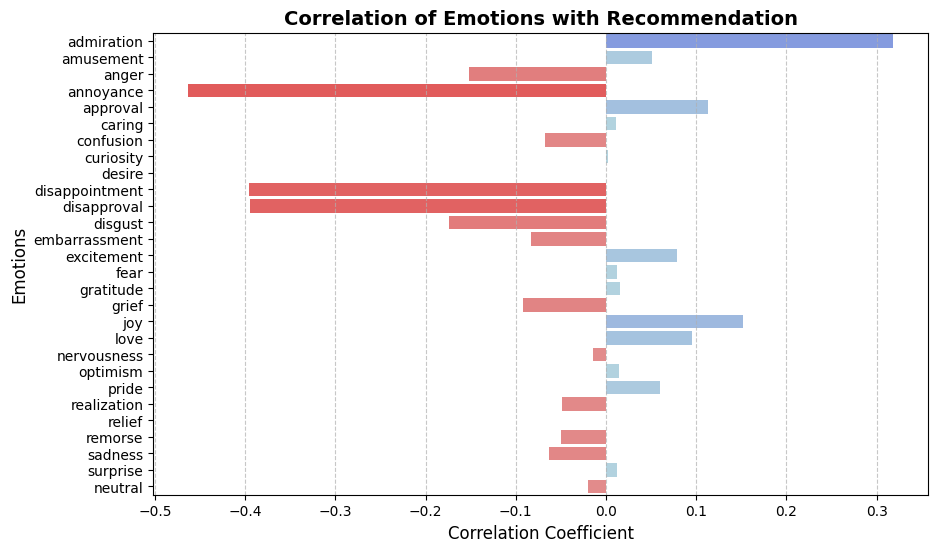

In [9]:
#generischer plot
plt.figure(figsize=(10, 6))
def color_fader(c1, c2, mix=0): 
    return mcolors.to_hex((1 - mix) * np.array(mcolors.to_rgb(c1)) + mix * np.array(mcolors.to_rgb(c2)))

colors = [color_fader('lightblue', 'blue', abs(c)) if c > 0 else color_fader('lightcoral', 'red', abs(c)) 
          for c in bool_correlations.values]

sns.barplot(y=bool_correlations.index, x=bool_correlations.values, palette=colors,legend=False,hue=bool_correlations.index)
plt.title("Correlation of Emotions with Recommendation", fontsize=14, fontweight='bold')
plt.ylabel("Emotions", fontsize=12)
plt.xlabel("Correlation Coefficient", fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

Was wir sehen können ist eine starke Korrelation zwischen negativen Emotionen und negativen Reviews und positive Emotionen und positiven Reviews. Dies sollte das Sentimentmodell verbessern und die Genauigkeit erhöhen.

In [ ]:
df_emotions_positive = df_strat_results.iloc[np.where(df_strat_results["recommended"]== True)].copy()
df_emotions_positive['emotion'] = df_emotions_positive.iloc[:,len(df_stratified.columns):].idxmax(axis=1)
df_emotions_positive = df_emotions_positive[['review_id','emotion','cleaned_review']]
df_emotions_positive = df_emotions_positive.merge(df_stratified_emotion, on='review_id', how='inner')
df_emotions_positive = df_emotions_positive[['review_id','emotion','cleaned_review']]

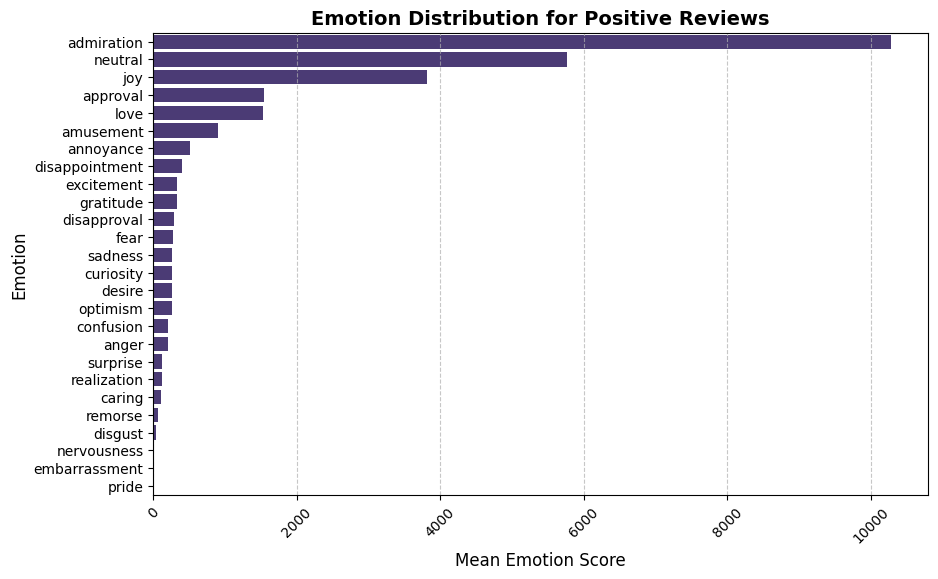

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette("viridis")

plt.figure(figsize=(10, 6))
positive_emotions_mean = df_emotions_positive.value_counts('emotion')
sns.barplot(y=positive_emotions_mean.index, x=positive_emotions_mean.values)
plt.title("Emotion Distribution for Positive Reviews", fontsize=14, fontweight='bold')
plt.xlabel("Mean Emotion Score", fontsize=12)
plt.ylabel("Emotion", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
df_emotions_negative = df_strat_results.iloc[np.where(df_strat_results["recommended"]== False)].copy()
df_emotions_negative['emotion'] = df_emotions_negative.iloc[:,len(df_stratified.columns):].idxmax(axis=1)
df_emotions_negative = df_emotions_negative[['review_id','emotion','cleaned_review']]
df_emotions_negative = df_emotions_negative.merge(df_stratified_emotion, on='review_id', how='inner')
df_emotions_negative = df_emotions_negative[['review_id','emotion','cleaned_review']]

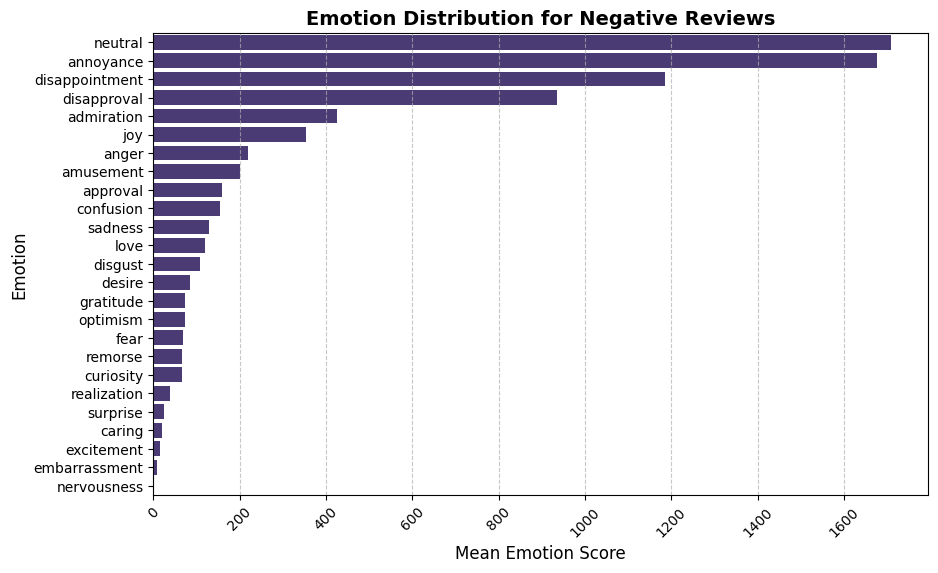

In [13]:
#generischer plot
sns.set_palette("viridis")

plt.figure(figsize=(10, 6))
negative_emotions_means = df_emotions_negative.value_counts('emotion')
sns.barplot(y=negative_emotions_means.index, x=negative_emotions_means.values)
plt.title("Emotion Distribution for Negative Reviews", fontsize=14, fontweight='bold')
plt.xlabel("Mean Emotion Score", fontsize=12)
plt.ylabel("Emotion", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

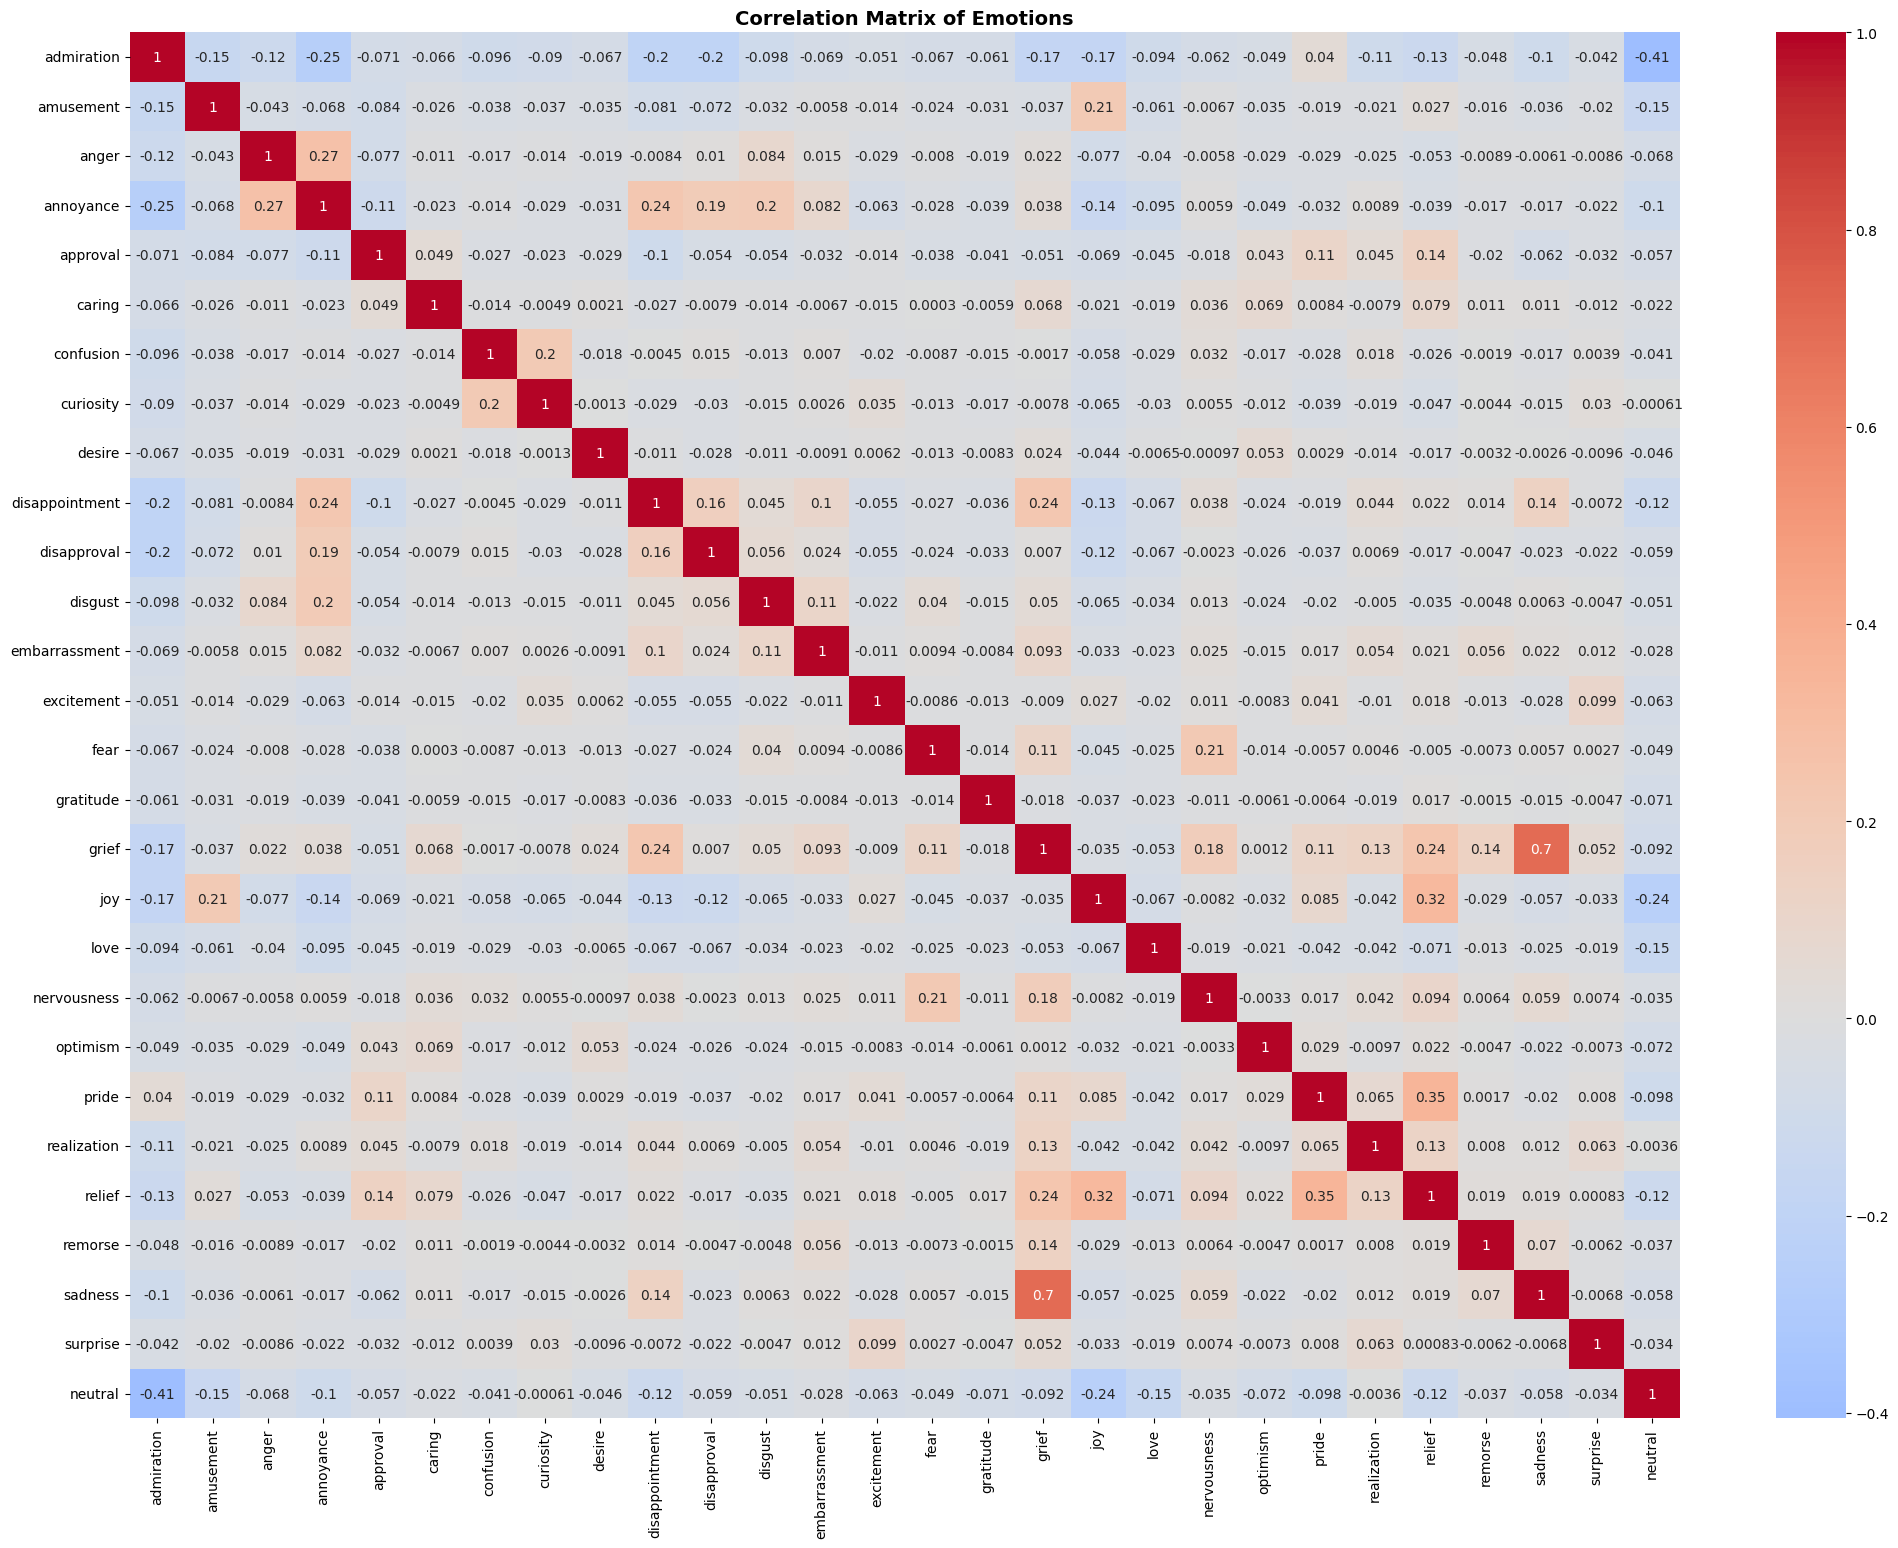

In [27]:
# Korrelationsmatrix der Emotionen berechnen
emotion_correlation_matrix = df_stratified_analyse[emotion_labels[:-1]].corr()

# Heatmap der Korrelationsmatrix plotten
plt.figure(figsize=(25, 18))
sns.heatmap(emotion_correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Matrix of Emotions", fontsize=14, fontweight='bold')
plt.show()

Wir sehen dass die Emotionen keine starken Korrelationen miteinander haben, außer einige, die sehr ähnlich per Definition sind. Dies ist gut für die Modellierung, da wir so mehr Informationen aus den Reviews bekommen, wenn die Emotionen nicht stark korrelieren.

### Fazit

Unsere Analyse der Steam Reviews hat gezeigt, dass die Emotionserkennung wertvolle Einblicke in die zugrunde liegenden Gefühle der Nutzer bietet. Die Korrelationen zwischen bestimmten Emotionen und der Empfehlung eines Spiels sind deutlich erkennbar. Insbesondere negative Emotionen wie "annoyance" und "disappointment" korrelieren stark mit negativen Bewertungen, während positive Emotionen wie "admiration" und "joy" häufiger in positiven Bewertungen vorkommen.

Durch die Integration der Emotionserkennung in unser Sentiment-Analyse-Modell hoffen wir, die Genauigkeit und Aussagekraft unserer Vorhersagen weiter zu verbessern. Emotionen bieten eine zusätzliche Dimension der Analyse, die über die reine Polarität von Bewertungen hinausgeht und uns hilft, die Nuancen der Nutzerzufriedenheit besser zu verstehen.

Wir sind zuversichtlich, dass die Berücksichtigung von Emotionen in der Sentiment-Analyse die Qualität unserer Ergebnisse erheblich steigern wird und freuen uns auf die weiteren Schritte in diesem spannenden Projekt.

### Berechnung der Emotionen für die gesamten Daten

Da alles schon bereit ist, können wir nun die Emotionen für die gesamten Daten berechnen und dann die Ergebnisse speichern.

In [7]:
df_emotion_results = process_emotion_scores_with_dataloader(df, model, tokenizer, batch_size = 16)
df_emotionen_results_analyse = map_emotion_scores_to_dataframe(df_emotion_results) # Emotionen in DataFrame umwandeln
df_emotionen_final = pd.merge(df,df_emotionen_results_analyse, on='review_id', how='left') #verbinden mit den ursprünglichen Daten

Verarbeite Batches:   0%|          | 0/22395 [00:00<?, ?it/s]c:\Users\Markus\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\models\roberta\modeling_roberta.py:370: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:545.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
Verarbeite Batches: 100%|██████████| 22395/22395 [1:09:41<00:00,  5.36it/s]   


In [8]:
df_emotionen_final.to_parquet("data/processed_data/steam_reviews_with_emotions_full.parquet")

In [9]:
df_emotionen_final.head()

,app_id,app_name,review_id,language,review,timestamp_created,timestamp_updated,recommended,votes_helpful,votes_funny,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,620980,Beat Saber,79244667,english,"Since I am 80 + years old, it is very importan...",2020-11-14 10:51:22,2020-11-14 10:51:22,True,1493,176,...,0.0011,0.0011,0.0946,0.0035,0.0109,0.0023,0.0005,0.0012,0.0013,0.3495
1,1113000,Persona 4 Golden,70806847,english,Please buy this game if you want more Persona ...,2020-06-15 02:03:47,2020-11-26 04:15:44,True,1490,31,...,0.0002,0.0000,0.0009,0.0000,0.0001,0.0001,0.0001,0.0001,0.0000,0.0003
2,1145360,Hades,75662801,english,You can date the medusa head. Post Launch Edi...,2020-09-08 19:18:50,2020-10-10 19:57:02,True,1486,745,...,0.0002,0.0000,0.0004,0.0000,0.0006,0.0000,0.0000,0.0000,0.0000,0.9934
3,1225330,NBA 2K21,75410143,english,There is very little difference from 2k20. The...,2020-09-04 06:20:35,2020-09-04 06:20:35,False,1484,99,...,0.0005,0.0072,0.0033,0.0012,0.0431,0.0021,0.0003,0.0042,0.0368,0.0299
4,105600,Terraria,78393147,english,---{Graphics}--- ✖ Masterpiece ✖ Beautiful ✅Go...,2020-10-30 12:14:22,2020-11-26 04:01:45,True,1461,156,...,0.0016,0.0003,0.0139,0.0006,0.0055,0.0004,0.0002,0.0009,0.0001,0.6998
